access the datasets on kaggle | https://www.kaggle.com/code/matyasvincze/svt-bencmarking

In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import norm as np_norm
import scipy.sparse as ss
from scipy.sparse.linalg import norm as ss_norm
from scipy.sparse.linalg import svds
# from sparsesvd import sparsesvd
import matplotlib.pyplot as plt
import math, random
from tqdm import tqdm
from numpy.linalg import svd
import copy

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/netflix-prize-data/combined_data_3.txt
/kaggle/input/netflix-prize-data/movie_titles.csv
/kaggle/input/netflix-prize-data/combined_data_4.txt
/kaggle/input/netflix-prize-data/combined_data_1.txt
/kaggle/input/netflix-prize-data/README
/kaggle/input/netflix-prize-data/probe.txt
/kaggle/input/netflix-prize-data/combined_data_2.txt
/kaggle/input/netflix-prize-data/qualifying.txt
/kaggle/input/goodbooks-10k-updated/book_tags.csv
/kaggle/input/goodbooks-10k-updated/ratings.csv
/kaggle/input/goodbooks-10k-updated/personalLibrary.csv
/kaggle/input/goodbooks-10k-updated/books.csv
/kaggle/input/goodbooks-10k-updated/to_read.csv
/kaggle/input/goodbooks-10k-updated/tags.csv
/kaggle/input/movierecommenderdataset/movies.csv
/kaggle/input/movierecommenderdataset/ratings.csv
/kaggle/input/movielens-20m-dataset/rating.csv
/kaggle/input/movielens-20m-dataset/link.csv
/kaggle/input/movielens-20m-dataset/genome_tags.csv
/kaggle/input/movielens-20m-dataset/genome_scores.csv
/kaggle/input/mov

In [25]:
wd = '../input/movierecommenderdataset' # working dir

n = np.inf
ratings = pd.read_csv(wd+'/ratings.csv',
                      header = 0,
                      names = ['user_id', 'movie_id', 'rating'],
                      usecols = [0,1, 2],
                      skiprows=lambda i: i > n)

ratings = ratings.pivot(index='user_id', columns='movie_id')
ratings.columns = [col[1] for col in ratings.columns]
ratings.index.name = None

print(f'Rating df shape | {ratings.shape}')
ratings.head(4)

Rating df shape | (610, 9724)


,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
n_nan = sum(ratings.isna().sum().values)
n_all = ratings.shape[0]*ratings.shape[1]
print(f'total # of values: {n_all}')
print(f'ration of NaN: {round(n_nan/n_all*100, 2)}%')

total # of values: 5931640
ration of NaN: 98.3%


In [27]:
n_masked = int((n_all - n_nan)/100)
print(f'masked {n_masked}/{n_all-n_nan} not NaN values for evaluation')
not_NaN_indexes = np.array(list(map(tuple, np.argwhere(~np.isnan(ratings.values)))))
masked_indexes = not_NaN_indexes[np.random.choice(not_NaN_indexes.shape[0], n_masked, replace=False)]

masked_ratings = copy.deepcopy(ratings)
for i, j in masked_indexes:
    masked_ratings.iloc[i, j] = np.nan

masked 1008/100836 not NaN values for evaluation


In [17]:
def SVT(M: pd.DataFrame,
        max_iter: int = 300,
        delta: int = 2,
        tolerance: float = 0.001,
        increment: int = 5, 
        min_rating: int = 1, 
        max_rating: int = 5):
    """
    Params:
        M: matrix to complite
        max_iter: maximum number of iterations
        delta: step-size
        tolerance: tolerance on the minimum improvement
        increment: how many new singular values to check if they fall below tau
    Returns:
        X, rmse: complited matrix, error list
    """
    M = ss.csr_matrix(M.fillna(0).values)  # pandas DF into scipy sparse matrix
    n, m = M.shape

    total_num_nonzero = len(M.nonzero()[0])
    idx = random.sample(range(total_num_nonzero), int(total_num_nonzero))
    Omega = (M.nonzero()[0][idx], M.nonzero()[1][idx])

    tau = 5 * math.sqrt(n * m)

    ######
    # SVT
    ######
    r = 0
    rmse = []
    data, indices = np.ravel(M[Omega]), Omega
    P_Omega_M = ss.csr_matrix((data, indices), shape=(n, m))
    k_0 = np.ceil(tau / (delta * ss_norm(P_Omega_M)))  # element-wise ceiling
    Y = k_0 * delta * P_Omega_M

    for _ in tqdm(range(max_iter+1), desc= "Iteratively filling the matrix", colour="green"):
        s = r + 1
        while True:
            # print("Y: ", Y)
            U, S, V = svd(ss.csc_matrix(Y).toarray(), s)      #svds(Y, 20)  # sparsesvd(ss.csc_matrix(Y), s)
            s += increment
            try:
                if S[s - increment] <= tau: break
            except:
                break

        r = np.sum(S > tau)

        U = U[:, :r]
        S = S[:r] - tau
        V = V[:r, :]

        X = (U * S).dot(V)

        X_omega = ss.csr_matrix((X[Omega], Omega), shape=(n, m))

        if ss_norm(X_omega - P_Omega_M) / ss_norm(P_Omega_M) < tolerance: break

        diff = P_Omega_M - X_omega
        Y += delta * diff
        rmse.append(np_norm(M[M.nonzero()] - X[M.nonzero()]) / np.sqrt(len(X[M.nonzero()])))
        X = X.clip(min_rating, max_rating)
        
        if _ % 50 == 0:
            avg_error = 0
            for i, j in masked_indexes:
                avg_error += abs(ratings.iloc[i, j] - pd.DataFrame(X).iloc[i, j])
            avg_error /= masked_indexes.shape[0]
            print(f'iter {_}')
            print(f'\t rmse last: {round(rmse[-1], 2)}')
            print(f'\t average error: {round(avg_error, 2)} ({round(avg_error/5*100, 2)}%)')
            print('-'*25)
            
    return X, rmse

In [18]:
pred_masked_ratings, rmse = SVT(masked_ratings, max_iter=1000)
pred_masked_ratings = pd.DataFrame(pred_masked_ratings)

Iteratively filling the matrix:   0%|          | 1/1001 [00:03<1:02:56,  3.78s/it]

iter 0
	 rmse last: 3.68
	 average error: 2.52 (50.33%)
-------------------------


Iteratively filling the matrix:   5%|▌         | 51/1001 [03:00<54:44,  3.46s/it]  

iter 50
	 rmse last: 1.43
	 average error: 1.25 (25.07%)
-------------------------


Iteratively filling the matrix:  10%|█         | 101/1001 [05:54<52:04,  3.47s/it]

iter 100
	 rmse last: 0.94
	 average error: 1.07 (21.45%)
-------------------------


Iteratively filling the matrix:  15%|█▌        | 151/1001 [08:51<50:48,  3.59s/it]

iter 150
	 rmse last: 0.63
	 average error: 1.04 (20.85%)
-------------------------


Iteratively filling the matrix:  20%|██        | 201/1001 [11:45<47:20,  3.55s/it]

iter 200
	 rmse last: 0.44
	 average error: 1.04 (20.9%)
-------------------------


Iteratively filling the matrix:  25%|██▌       | 251/1001 [14:40<45:02,  3.60s/it]

iter 250
	 rmse last: 0.32
	 average error: 1.05 (21.06%)
-------------------------


Iteratively filling the matrix:  30%|███       | 301/1001 [17:37<40:44,  3.49s/it]

iter 300
	 rmse last: 0.24
	 average error: 1.07 (21.36%)
-------------------------


Iteratively filling the matrix:  35%|███▌      | 351/1001 [20:33<38:37,  3.57s/it]

iter 350
	 rmse last: 0.19
	 average error: 1.07 (21.49%)
-------------------------


Iteratively filling the matrix:  40%|████      | 401/1001 [23:27<35:05,  3.51s/it]

iter 400
	 rmse last: 0.15
	 average error: 1.08 (21.67%)
-------------------------


Iteratively filling the matrix:  45%|████▌     | 451/1001 [26:25<33:00,  3.60s/it]

iter 450
	 rmse last: 0.13
	 average error: 1.09 (21.75%)
-------------------------


Iteratively filling the matrix:  50%|█████     | 501/1001 [29:19<29:11,  3.50s/it]

iter 500
	 rmse last: 0.1
	 average error: 1.09 (21.82%)
-------------------------


Iteratively filling the matrix:  55%|█████▌    | 551/1001 [32:18<28:10,  3.76s/it]

iter 550
	 rmse last: 0.09
	 average error: 1.09 (21.85%)
-------------------------


Iteratively filling the matrix:  60%|██████    | 601/1001 [35:15<23:20,  3.50s/it]

iter 600
	 rmse last: 0.08
	 average error: 1.09 (21.86%)
-------------------------


Iteratively filling the matrix:  65%|██████▌   | 651/1001 [38:12<20:46,  3.56s/it]

iter 650
	 rmse last: 0.06
	 average error: 1.09 (21.87%)
-------------------------


Iteratively filling the matrix:  70%|███████   | 701/1001 [41:10<17:44,  3.55s/it]

iter 700
	 rmse last: 0.06
	 average error: 1.09 (21.88%)
-------------------------


Iteratively filling the matrix:  75%|███████▌  | 751/1001 [44:06<14:41,  3.53s/it]

iter 750
	 rmse last: 0.05
	 average error: 1.09 (21.89%)
-------------------------


Iteratively filling the matrix:  80%|████████  | 801/1001 [47:02<11:40,  3.50s/it]

iter 800
	 rmse last: 0.04
	 average error: 1.09 (21.89%)
-------------------------


Iteratively filling the matrix:  85%|████████▌ | 851/1001 [49:57<08:49,  3.53s/it]

iter 850
	 rmse last: 0.04
	 average error: 1.09 (21.88%)
-------------------------


Iteratively filling the matrix:  90%|█████████ | 901/1001 [52:51<05:45,  3.45s/it]

iter 900
	 rmse last: 0.03
	 average error: 1.09 (21.88%)
-------------------------


Iteratively filling the matrix:  95%|█████████▌| 951/1001 [55:47<03:01,  3.63s/it]

iter 950
	 rmse last: 0.03
	 average error: 1.09 (21.88%)
-------------------------


Iteratively filling the matrix: 100%|██████████| 1001/1001 [58:45<00:00,  3.52s/it]

iter 1000
	 rmse last: 0.03
	 average error: 1.09 (21.89%)
-------------------------


---

In [2]:
n_iter = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]

rmse_movielens = [3.68447466, 1.43196593, 0.93646816, 0.63462738, 0.44330577, 0.32134767, 0.24408486, 
                  0.19142314, 0.15414554, 0.12609739, 0.10490908, 0.08843546, 0.0753577, 0.06482671, 
                  0.05607537, 0.04896684, 0.04296915, 0.03794193, 0.03369748, 0.03008473, 0.02696989]
err_percent_movielens = [50.33, 25.07, 21.45, 20.85, 20.9, 21.06, 21.36, 21.49, 21.67, 21.75, 21.82, 21.85, 21.86, 21.87, 21.88, 21.89, 21.89, 21.88, 21.88, 21.88, 21.89]
err_value_movielens = [round(_*0.05, 4) for _ in err_percent_movielens]

rmse_movierecom = [3.65282942, 1.62022548, 1.21380015, 0.99539064, 0.8345412, 0.69010682, 0.57910294, 
         0.48779341, 0.4128615, 0.35258444,0.30361977, 0.26372163, 0.23132413, 0.20423935, 
         0.18133975, 0.16199162, 0.14523244, 0.1310238 , 0.11880495, 0.10819318, 0.0989306]
err_percent_movierecom = [51.68, 24.95, 20.29, 18.17, 17.17, 16.92, 16.61, 16.5, 16.61, 16.72, 16.75, 16.75, 16.77, 16.76, 16.76, 16.77, 16.78, 16.79, 16.79, 16.8, 16.83]
err_value_movierecom = [round(_*0.05, 4) for _ in err_percent_movierecom]


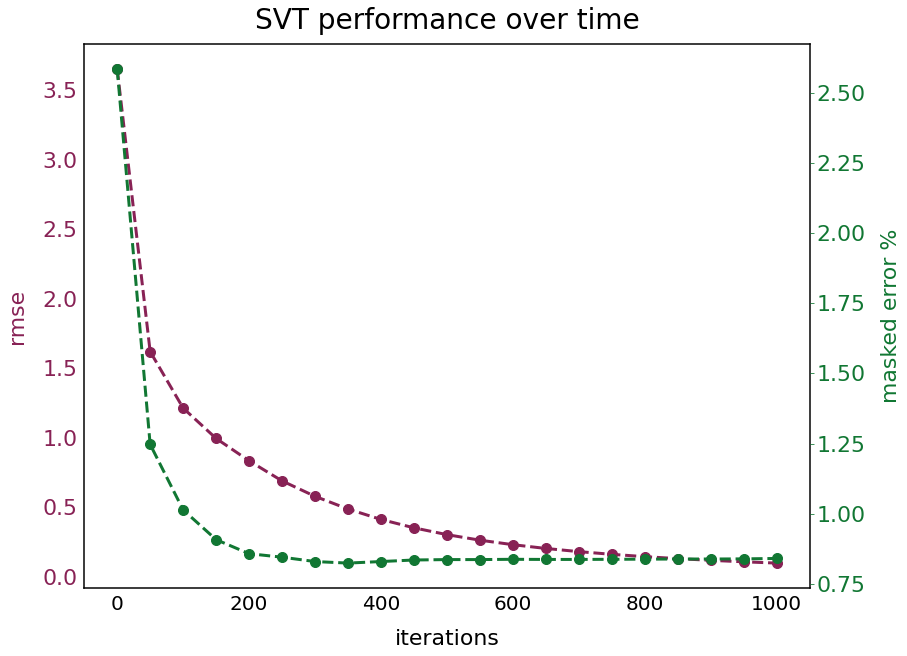

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(13, 10))
ax = fig.add_subplot(111, label="1")
ax_ = fig.add_subplot(111, label="2", frame_on=False)

ax.plot(n_iter, rmse, marker='o', markersize=10, linestyle='--', color='#882255', lw=3)
ax.tick_params(bottom=False, left=False)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', colors='#882255', labelsize=22)
ax.set_axisbelow(True)
ax.yaxis.grid(False)
ax.xaxis.grid(False)
ax.set_xlabel('iterations', fontsize=22, labelpad=15)
ax.set_ylabel('rmse', fontsize=22, labelpad=15, color='#882255')
for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(1.5)

ax_.plot(n_iter, err_value, marker='o', markersize=10, linestyle='--', color='#117733', lw=3)
ax_.set_xticks([])
ax_.yaxis.tick_right()
ax_.set_ylabel('masked error %', color='#117733', fontsize=22, labelpad=15)
ax_.yaxis.set_label_position('right')
ax_.tick_params(axis='y', colors='#117733', labelsize=22)

plt.title('SVT performance over time', pad=15, fontsize=28)
plt.savefig('SVT_movies.png', bbox_inches="tight", dpi=400)

In [103]:
5-3

2

In [108]:
np_norm([2, 2]) / np.sqrt(2)

2.0

In [ ]:
1